<a href="https://colab.research.google.com/github/Jazzy-cats/AstraZenecaHackathon/blob/master/notebooks/04_Sample_Train_test_split_AstraZeneca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/Jazzy-cats/AstraZenecaHackathon.git

Cloning into 'AstraZenecaHackathon'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 88 (delta 10), reused 6 (delta 1), pack-reused 65
Unpacking objects: 100% (88/88), done.
Checking out files: 100% (51/51), done.


In [4]:
!cp -r /content/AstraZenecaHackathon/images_for_preview /content/

In [5]:
!pip install -U albumentations
!pip install --upgrade wandb

     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 952kB 7.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=931e901a6e229d16f2f6862c0990e87a0f016d5edb5239e6cf084c159b9c060c
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 1.7MB 2.8MB/s 
     |████████████████████████████████| 163kB 16.7MB/s 
     |████████████████████████████████| 122kB 18.1MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 

In [6]:
!wandb login 4cd26b2ff55146e40709211e779eb16784453f8e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
!pip install pylocron

     |████████████████████████████████| 61kB 1.9MB/s 


In [8]:
import os
import shutil
import glob
import logging
import random
from pathlib import Path

import cv2
import PIL.Image as Image
#from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.models import resnet152
import albumentations as A
from fastai.vision.models import DynamicUnet
import holocron.models as models  # For UNet++ and UNet+++

In [9]:
# Init wandb
import wandb
wandb.init(project='astrazeneca')

wandb: Currently logged in as: llanojairo (use `wandb login --relogin` to force relogin)


In [10]:
def get_image_metadata(path_to_file):
    """Function for extracting metadata from filename of dataset provided by AstraZeneca.
    
    B02   - well (row B, column 02) 
    T0001 - timepoint (irrelevant for this dataset) 
    F001  - field of view = site 
    L01   - timeline (irrelevant for this datset) 
    A01   - action list number (3 fluorescent + 1 brightfield action) 
    Z01   - 3D z-number (slice number or vertical position) 
    C01   - imaging channel (1 nuclear, 2 lipids, 3 cytoplasm, 4 brightfield)
    """
    string_arr = os.path.basename(path_to_file).split("_")
    row_col = string_arr[-2] # Row and column
    timepoint = string_arr[-1][:5]
    fied_of_view = string_arr[-1][5:9]
    timeline = string_arr[-1][9:12]
    action_list_number = string_arr[-1][12:15]
    z_number_3d = string_arr[-1][15:18]
    imaging_channel = string_arr[-1][18:21]
    return {
        "row_col":       row_col,
        #"timepoint":     timepoint,  # apparently irrelevant
        "field of view": fied_of_view,
        #"timeline": timeline,  # apparently irrelevant
        "action_list_number": action_list_number,
        "z_number_3d": z_number_3d,
        "imaging_channel": imaging_channel,
        "path": path_to_file
    }

In [11]:
def divide_astra_zeneca_train_validation(dataset_path="/content/images_for_preview", train_ratio=0.5):
    """Divide sample images for the Astra Zeneca competition into training and validation sets.

    Group by row_col and field of view
    # row_col
    # field of view
      
    Input and Target share these common values:
    - row_col       = sample id? 
    - field of view = amount of zoom

    For identifying INPUT:
    - action_list_number A04
    - imaging_channel    C04
    - z_number_3d        Z01 - Z07

    For identifying TARGET:
    - action_list_number A01 A02 and A03
    - imaging_channel    C01, C02, C03
    - z_number_3d        Z01
    """

    dataset_samples = glob.glob(os.path.join(dataset_path, "*/*/Assay*"))

    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    for sample_dict in dataset_dicts:
        sample_key = (sample_dict["row_col"], sample_dict["field of view"])

        if samples.get(sample_key) is None:
            samples[sample_key] = {
                "input": dict(),
                "target": dict()
            }

        if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        else:
            # Is an target
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["target"][action_list_number] = sample_dict["path"]

    samples = list(samples.values())

    # Modulo
    if os.path.isdir("train"):
        shutil.rmtree("train")
    if os.path.isdir("valid"):
        shutil.rmtree("valid")

    Path("valid/input").mkdir(exist_ok=True, parents=True)
    Path("valid/targets").mkdir(exist_ok=True, parents=True)
    Path("train/input").mkdir(exist_ok=True, parents=True)
    Path("train/targets").mkdir(exist_ok=True, parents=True)

    crop_size = (256, 256)

    for idx in range(len(samples)):
        sample_dict = samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert crop_size[0] <= w
        assert crop_size[1] <= h

        input = torch.zeros((7, w, h))
        output = torch.zeros((3, w, h))
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            img = cv2.imread(img_path, -1)

            w, h = img.shape
            
            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join("train/input", filename)
            save_path_valid = os.path.join("valid/input", filename)
            cv2.imwrite(save_path_train, train_img)
            cv2.imwrite(save_path_valid, valid_img)

        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            img = cv2.imread(img_path, -1)

            cut_off_idx = int(w*train_ratio)

            train_img = img[:cut_off_idx]
            valid_img = img[cut_off_idx:]

            filename = os.path.basename(img_path)
            save_path_train = os.path.join("train/targets", filename)
            save_path_valid = os.path.join("valid/targets", filename)
            cv2.imwrite(save_path_train, train_img)
            cv2.imwrite(save_path_valid, valid_img)

divide_astra_zeneca_train_validation(train_ratio=0.5)

# Exploratory Data Analysis

Let's look at the distribution of the pixel values and see if we can transform into normal distribution

In [12]:
sns.set_style("darkgrid")

1202.8019969061604 1042.610844193137
6.755601122254536 0.8176324593078337


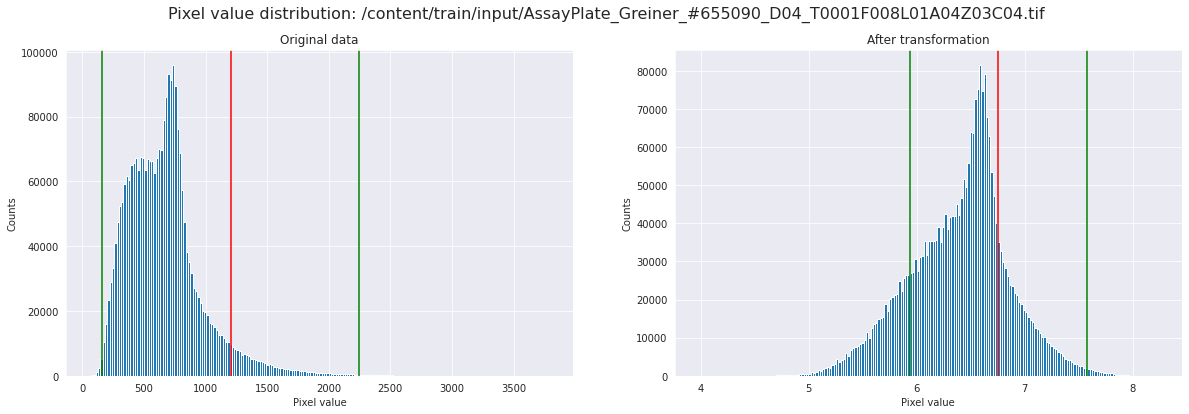

386.7342269355511 496.481619043447
5.535812759480006 0.8632382459669632


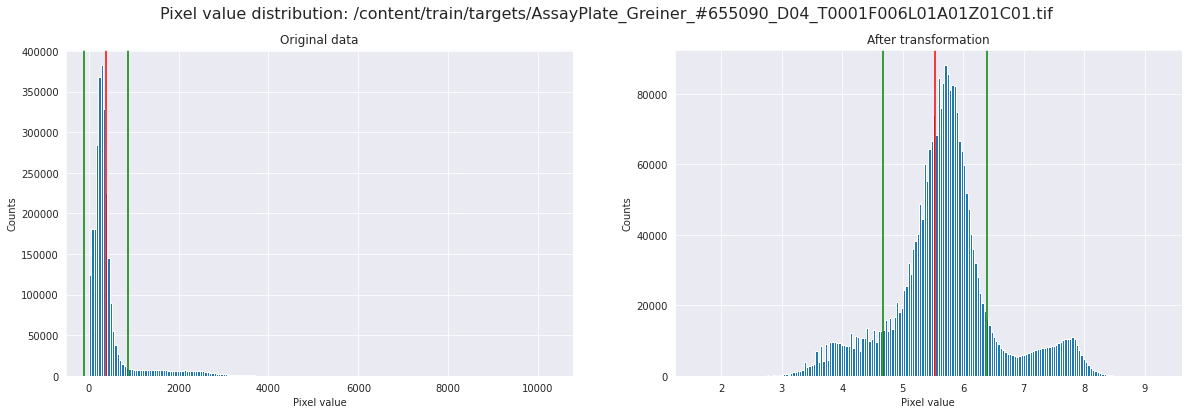

1041.794960027327 902.8091549723304
28.412378 15.314437


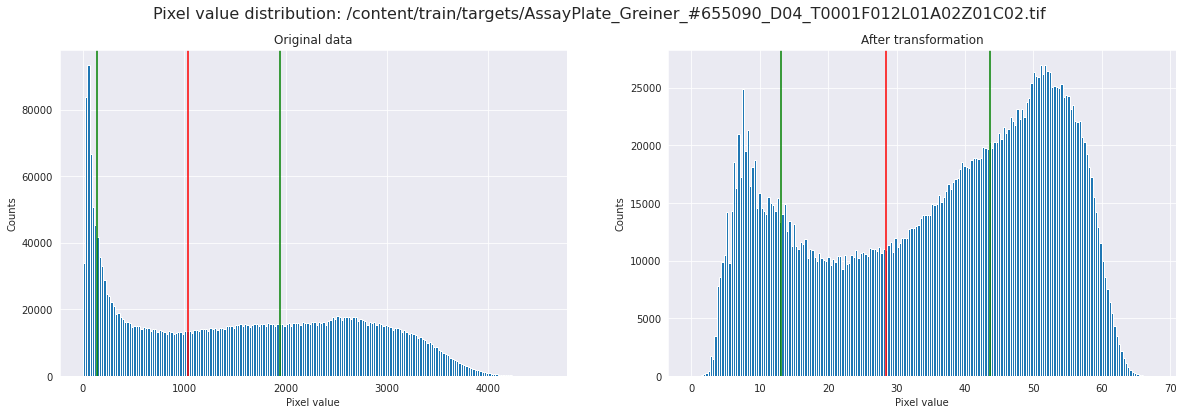

495.6821676825969 261.8310766387653
6.078363909588415 0.5072928130987974


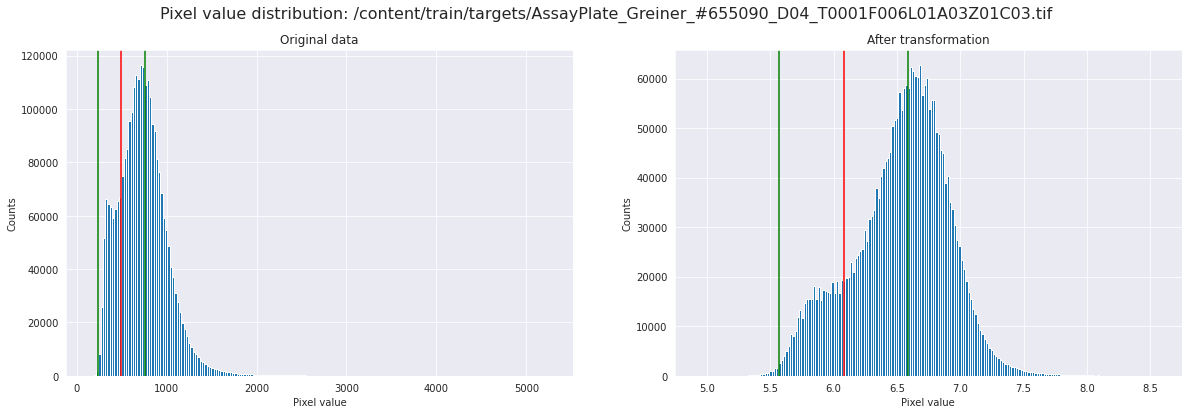

In [13]:
input = glob.glob("/content/train/input/*") # log
target1 = glob.glob("/content/train/targets/*A01*")
target2 = glob.glob("/content/train/targets/*A02*")
target3 = glob.glob("/content/train/targets/*A03*") # log

def get_mean_and_std(paths, func=None):
    pixel_values = list()
    for i in paths:
        img = cv2.imread(i, -1)
        if func is not None:
            img = func(img)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    return np.mean(pixel_values), np.std(pixel_values)

def plot_histogram_w_stats(img_path, mean, std, func=None, ax=None):
    img = cv2.imread(img_path, -1)

    if func is not None:
        img = func(img)
    #plt.figure(figsize=(20,6))
    ax.hist(img.ravel(), 200)
    ax.axvline(x=mean,color='red')
    ax.axvline(x=mean+std,color='green')
    ax.axvline(x=mean-std,color='green')
    #plt.show()

def plot_histograms_w_stats(paths, sample_idx=0, transform=None):

    fig, axs = plt.subplots(1,2, figsize=(20,6))
    fig.suptitle(f"Pixel value distribution: {paths[0]}", fontsize=16)
    axs[0].set_title('Original data')
    axs[1].set_title('After transformation')
    axs[0].set_xlabel('Pixel value')
    axs[0].set_ylabel('Counts')
    axs[1].set_xlabel('Pixel value')
    axs[1].set_ylabel('Counts')

    mean, std = get_mean_and_std(paths)
    print(mean, std)
    plot_histogram_w_stats(paths[sample_idx], mean, std, ax=axs[0])

    mean, std = get_mean_and_std(paths, func=transform)
    print(mean, std)
    plot_histogram_w_stats(paths[sample_idx], mean, std, func=transform, ax=axs[1])
    plt.show()
    

log_func = lambda x: np.log(x + 1e-3)

# 1250.8056198505967 1084.9798588268861
# 6.789944517079453 0.8247920659414303 - np.log(x + 1e-3)
plot_histograms_w_stats(input, transform=log_func)

# 378.4063635628563 486.62929332530007
# 5.5090300908038135 0.8687941890567182 - np.log(x + 1e-3)
plot_histograms_w_stats(target1, transform=log_func)

# 988.0271635755419 898.4957144105864
# 27.253351 15.661491 - np.sqrt
plot_histograms_w_stats(target2, transform=np.sqrt)

# 482.04090429532835 254.4028682542436
# 6.054861212228503 0.49684806276264926 - np.log(x + 1e-3)
plot_histograms_w_stats(target3, transform=log_func)


2549.633785910758 921.5979619477422
7.778009193408933 0.3752124115988104


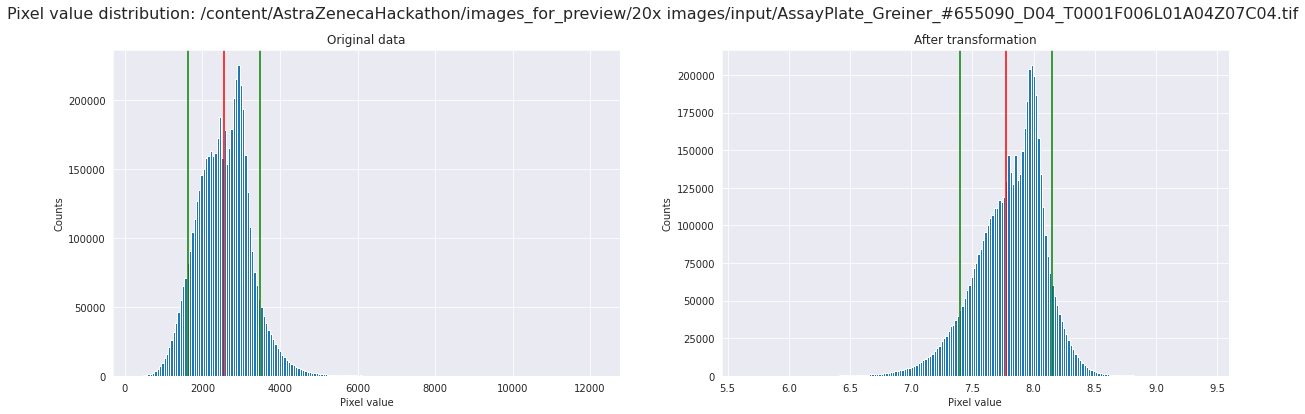

686.3515886340513 288.4937002602397
6.4462855764674565 0.42147736588603485


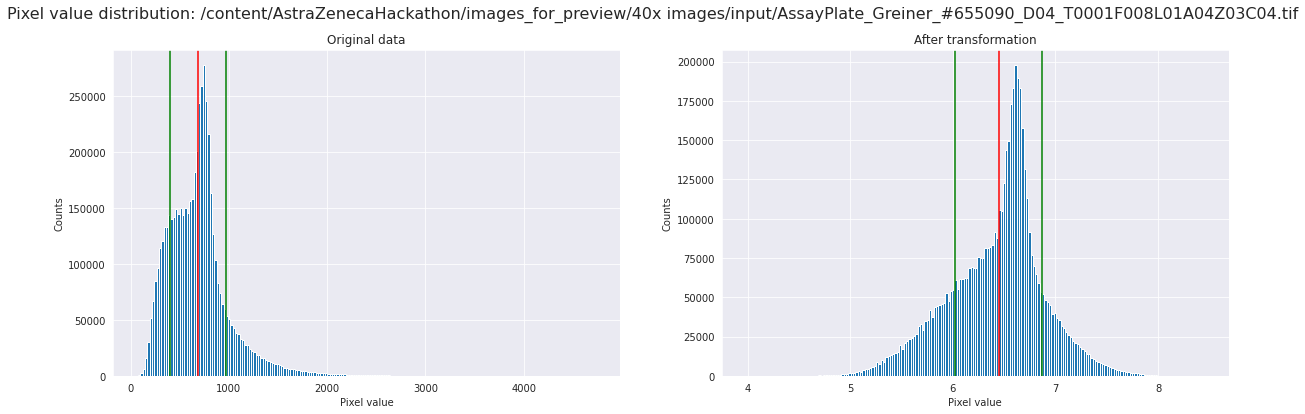

497.29094745010906 255.4639683997631
6.052975440042164 0.6434749126006335


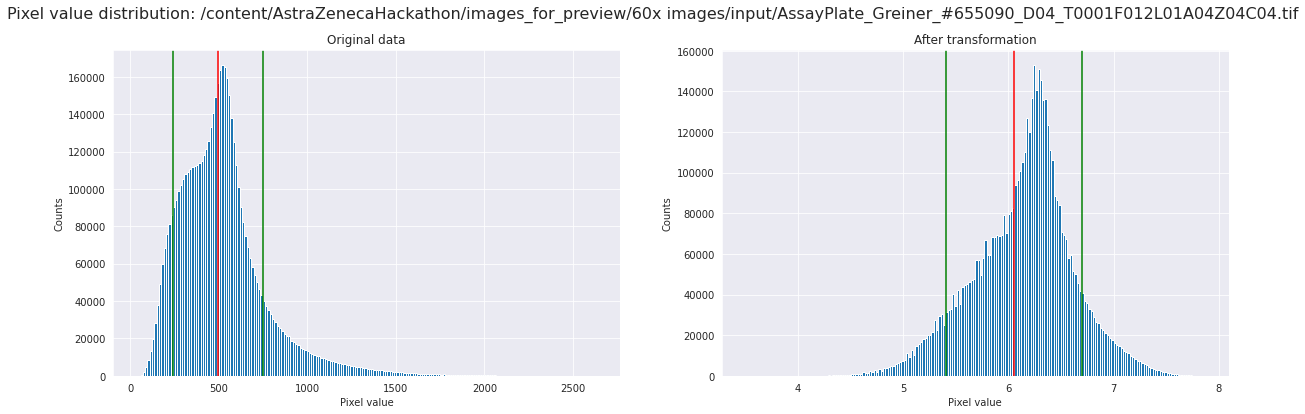

In [16]:
input1 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/20x images/input/*") # log
input2 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/40x images/input/*") # log
input3 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/60x images/input/*") # log

log_func = lambda x: np.log(x + 1e-3)

plot_histograms_w_stats(input1, transform=log_func)
plot_histograms_w_stats(input2, transform=log_func)
plot_histograms_w_stats(input3, transform=log_func)

421.2198833879021 523.1345710838092
5.614951453142896 0.8769242855685524


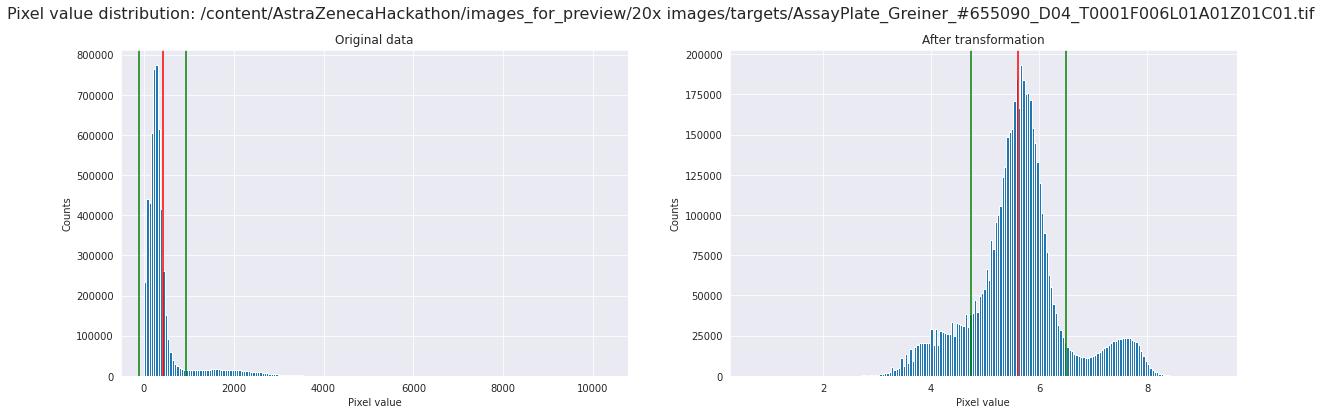

386.27942129690115 507.1807462537726
5.5158657397464 0.891364730584584


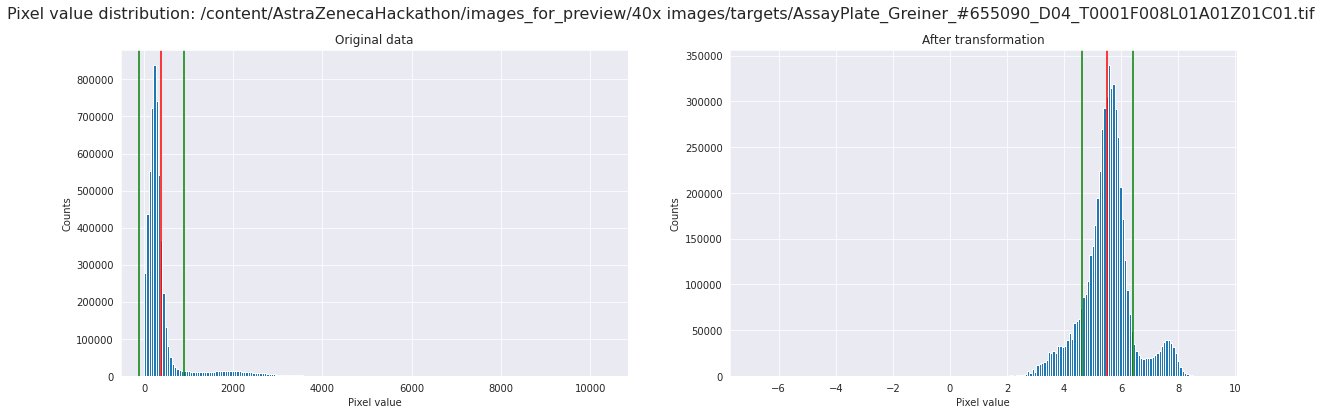

327.792971029641 418.4872338306652
5.396454140497149 0.8227920617918514


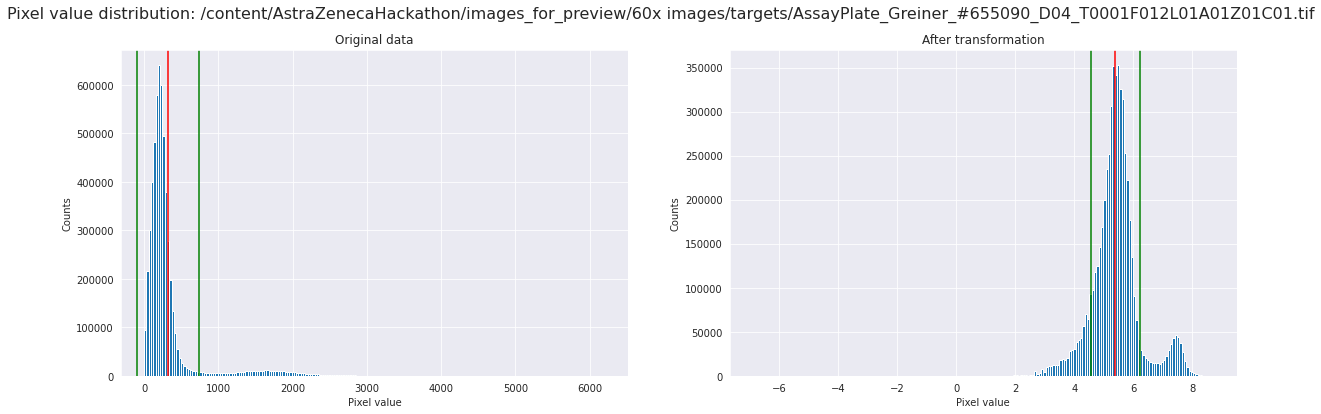

In [18]:
input1 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/20x images/targets/*A01*") # log
input2 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/40x images/targets/*A01*") # log
input3 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/60x images/targets/*A01*") # log
  
log_func = lambda x: np.log(x + 1e-3)

plot_histograms_w_stats(input1, transform=log_func)
plot_histograms_w_stats(input2, transform=log_func)
plot_histograms_w_stats(input3, transform=log_func)

699.4002086046321 647.1288960083931
22.472029 13.943031


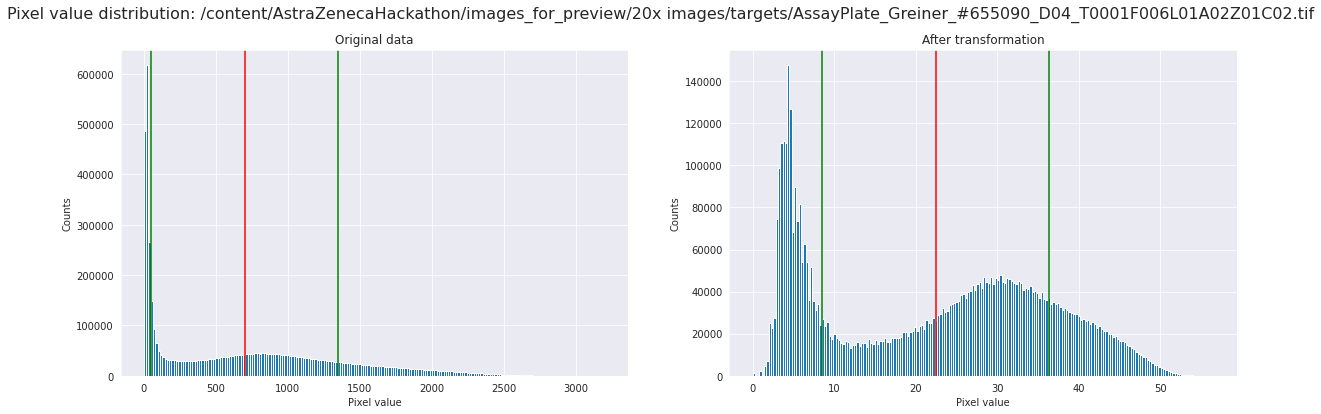

715.3041735260045 570.8349827211225
23.524591 12.723908


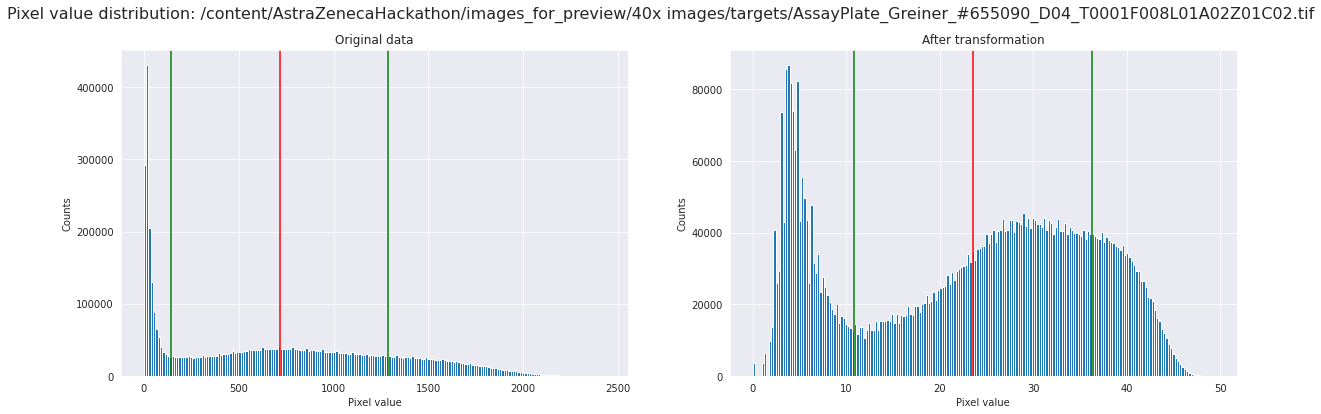

1548.8837324088834 1097.4926391826002
35.75525 16.445267


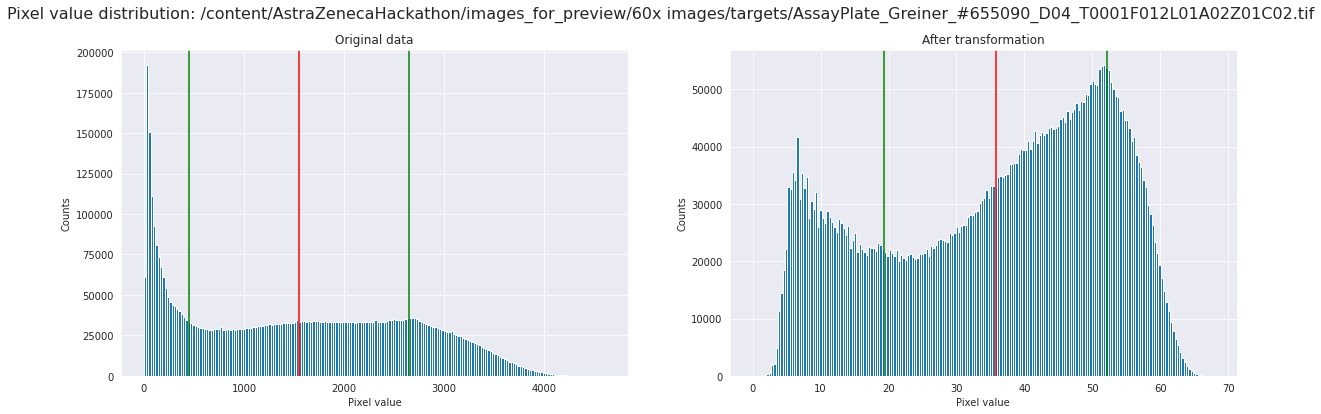

In [19]:
input1 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/20x images/targets/*A02*") # log
input2 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/40x images/targets/*A02*") # log
input3 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/60x images/targets/*A02*") # log
  
log_func = lambda x: np.log(x + 1e-3)

plot_histograms_w_stats(input1, transform=np.sqrt)
plot_histograms_w_stats(input2, transform=np.sqrt)
plot_histograms_w_stats(input3, transform=np.sqrt)


#plot_histograms_w_stats(target1, transform=log_func)
#plot_histograms_w_stats(target2, transform=np.sqrt)
#plot_histograms_w_stats(target3, transform=log_func)


699.4151475755983 282.3553136906496
6.474631630812637 0.39312451845996244


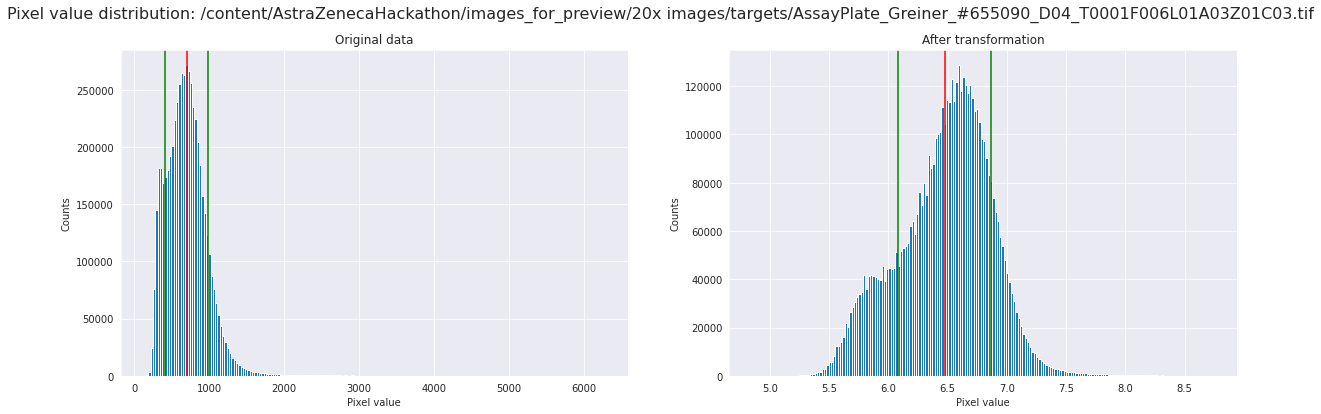

405.234622925141 156.40359376080448
5.930925110848701 0.38944974056617093


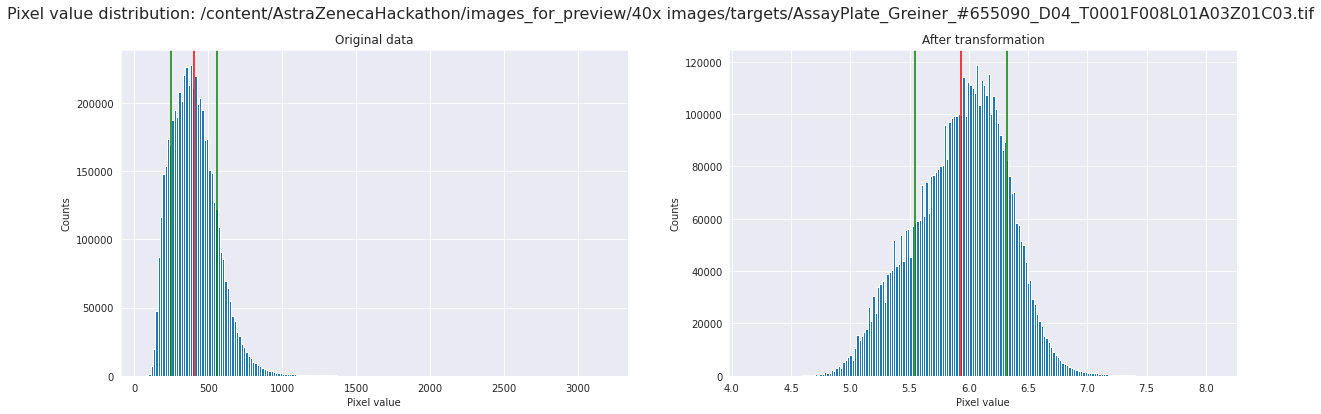

341.84451986086793 131.44001168284134
5.759744446607676 0.39476340923003955


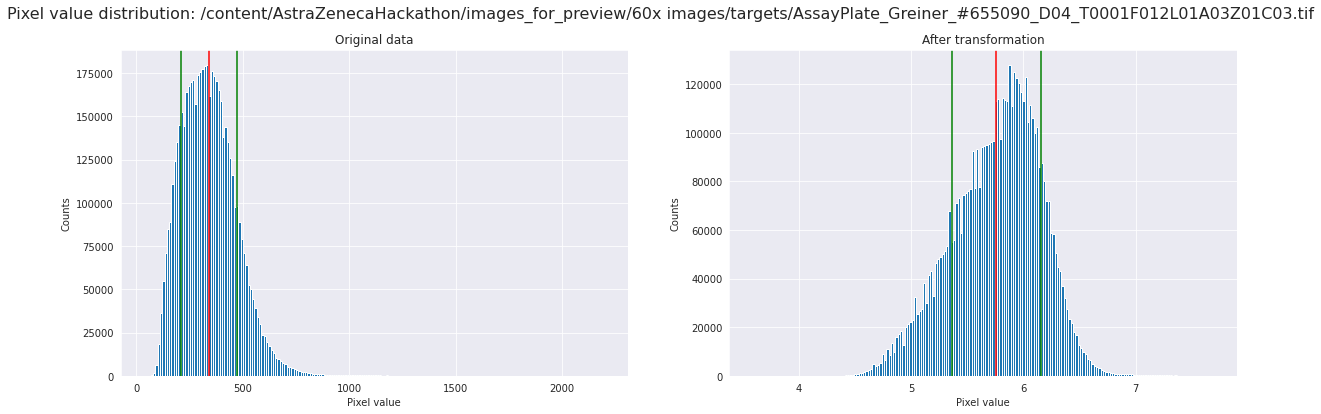

In [20]:
input1 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/20x images/targets/*A03*") # log
input2 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/40x images/targets/*A03*") # log
input3 = glob.glob("/content/AstraZenecaHackathon/images_for_preview/60x images/targets/*A03*") # log
  
log_func = lambda x: np.log(x + 1e-3)

plot_histograms_w_stats(input1, transform=log_func)
plot_histograms_w_stats(input2, transform=log_func)
plot_histograms_w_stats(input3, transform=log_func)

# Creating a PyTorch Dataset and DataLoader for training

In [ ]:
class ExampleDataset(Dataset):

    def __init__(self, dataset_path, crop_size=(256,256), transform=None, train=True):
        """Example dataset for sample images for the Astra Zeneca competition
        
        Group by row_col and field of view
        # row_col
        # field of view
         
        Input and Target share these common values:
        - row_col       = sample id? 
        - field of view = amount of zoom

        For identifying INPUT:
        - action_list_number A04
        - imaging_channel    C04
        - z_number_3d        Z01 - Z07

        For identifying TARGET:
        - action_list_number A01 A02 and A03
        - imaging_channel    C01, C02, C03
        - z_number_3d        Z01
        """
        self.dataset_path = dataset_path
        
        dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/*/Assay*"))
        if len(dataset_samples) == 0: # Bad solution 
            dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/Assay*"))

        dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
        
        # Group all 7 inputs with all 3 respective targets into variable sample
        samples = dict()
        for sample_dict in dataset_dicts:
            sample_key = (sample_dict["row_col"], sample_dict["field of view"])

            if samples.get(sample_key) is None:
                samples[sample_key] = {
                    "input": dict(),
                    "target": dict()
                }

            if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
                # Is an input
                z_number_3d = sample_dict["z_number_3d"]
                samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
            else:
                # Is an target
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["target"][action_list_number] = sample_dict["path"]

        self.samples = list(samples.values())
        self.crop_size = crop_size
        self.transforms = transform
        self.train = train
        
    def __len__(self):
        return 200

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Modulo
        idx = idx % len(self.samples)

        sample_dict = self.samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert self.crop_size[0] <= w
        assert self.crop_size[1] <= h

        input = torch.zeros((7, w, h))
        output = torch.zeros((3, w, h))
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            img = cv2.imread(img_path, -1)

            img = img.astype(np.int32)
            input[i] = torch.Tensor(img)

        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            img = cv2.imread(img_path, -1)

            img = img.astype(np.int32)
            output[i] = torch.Tensor(img)

        if self.transforms:
            for transform in self.transforms:
                input, output = transform(input, output)

        return input, output

train_dataset = ExampleDataset("/content/train/")
valid_dataset = ExampleDataset("/content/valid/")

# Testing
x, y = train_dataset[0]
print(x.shape, y.shape)
x, y = valid_dataset[0]
print(x.shape, y.shape)

del train_dataset
del valid_dataset,x ,y

torch.Size([7, 1077, 2554]) torch.Size([3, 1077, 2554])
torch.Size([7, 1077, 2554]) torch.Size([3, 1077, 2554])


# Creating Data Augmentations
We will be using the following augmentations

Affine transformations
- Horizontal/Vertical flipping
- Rotation 
- Rescale and Crop 
- Shear (Not implemented)

Color transformations
- ??
- Channel shuffle (Not implemented)

Distortion transformations
- Grid distortion (Not implemented)
- Elastic transform (Not implemented)


## List from 1st place winner of 2018 Data Science Bowl
- Clahe, Sharpen, Emboss
- Gaussian Noise
- Color to Gray
- Inverting - we should not have used it, some images were not predicted correctly on stage2 because of this augmentation
- Remapping grayscale images to random color images
- Blur, Median Blur, Motion Blur
- contrast and brightness
- random scale, rotates and flips
- Heavy geometric transformations: Elastic Transform, Perspective
- Transform, Piecewise Affine transforms, pincushion distortion
- Random HSV
- Channel shuffle - I guess this one was very important due to the nature of the data
- Nucleus copying on images. That created a lot of overlapping nuclei.
- It seemed to help networks to learn better borders for overlapping nuclei.

In [ ]:
class RandomRotation:
    """Rotate by one of the given angles."""

    def __init__(self, p=0.5, angles=30):
        self.p = p
        self.angles = angles

    def __call__(self, input, output):
        if random.random() < self.p:
            angle = random.uniform(-self.angles, self.angles)

            for i in range(len(input)):
                values = input[i].getextrema()
                avg = int(sum(values)/len(values))
                input[i] = TF.rotate(input[i], angle, fill=avg)
            for i in range(len(output)):
                values = output[i].getextrema()
                avg = int(sum(values)/len(values))
                output[i] = TF.rotate(output[i], angle, fill=0)

        return input, output


class HorizontalFlipping:
    """Flip horizontally."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            input = TF.hflip(input)
            output = TF.hflip(output)
        return input, output

class VerticalFlipping:
    """Flip vertically."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            input = TF.vflip(input)
            output = TF.vflip(output)
        return input, output

class Normalize:
    """Normalize values."""

    def __init__(self, input_stats, output_stats=None):
        self.input_mean, self.input_std = input_stats
        self.output_mean, self.output_std = output_stats

    def __call__(self, input, output):
        input = (input - self.input_mean)/self.input_std
        output = (output - self.output_mean)/self.output_std
        return input, output

class DistributionTransform:
    """Transform distribution to be normally distributed."""

    def __init__(self):
        pass

    def __call__(self, input, output):
        input = torch.log(input + 1e-3)
        output[0] = torch.log(output[0] + 1e-3)
        output[1] = torch.sqrt(output[1])
        output[2] = torch.log(output[2] + 1e-3)
        return input, output

class ToPIL:
    """
    """
    def __init__(self):
        pass

    def __call__(self, input, output):
        pil_input = list()
        pil_output = list()
        for i in range(len(input)):
            pil_input.append(Image.fromarray(np.array(input[i], dtype=np.uint16), "I;16"))
        for i in range(len(output)):
            pil_output.append(Image.fromarray(np.array(output[i], dtype=np.uint16), "I;16"))
        return pil_input, pil_output

class ToTensor:
    """
    """
    def __init__(self):
        pass

    def __call__(self, input, output):
        torch_input = list()
        torch_output = list()
        for i in input:
            torch_input.append(TF.to_tensor(i))
        for i in output:
            torch_output.append(TF.to_tensor(i))
        torch_input = torch.cat(torch_input, 0)
        torch_output = torch.cat(torch_output, 0)
        return torch_input, torch_output

class Crop:
    """
    """
    def __init__(self, crop_size, ratio=0.2):
        self.crop_size = crop_size
        self.ratio = ratio

    def __call__(self, input, output):

        width, height = input[0].size

        factor = 1 + random.uniform(0, self.ratio)
        crop_width = self.crop_size[1] * factor
        crop_height = self.crop_size[0] * factor

        crop_x = np.random.randint(0, width - crop_width)
        crop_y = np.random.randint(0, height - crop_height)
        
        for idx, img in enumerate(input):
            input[idx] = TF.crop(img, crop_y, crop_x, crop_height, crop_width)

        for idx, img in enumerate(output):
            output[idx] = TF.crop(img, crop_y, crop_x, crop_height, crop_width)
        return input, output

class Resize:
    """
    """
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, input, output):

        new_input = torch.zeros((7, self.crop_size[0], self.crop_size[1]))
        new_output = torch.zeros((3, self.crop_size[0], self.crop_size[1]))
        for idx, img in enumerate(input):
            new_input[idx] = torch.Tensor(cv2.resize(img.float().numpy(), self.crop_size))

        for idx, img in enumerate(output):
            new_output[idx] = torch.Tensor(cv2.resize(img.float().numpy(), self.crop_size))
        return new_input, new_output

# For post-processing comparisons
def post_process(target):
    output_stats = torch.Tensor([
        [378.4063635628563,  988.0271635755419, 482.04090429532835],
        [486.62929332530007, 898.4957144105864, 254.4028682542436]
    ]).float()
    output_stats = output_stats.view(2,1,3,1,1)
    # (batch, channel, width, height)
    target = target*output_stats[1] + output_stats[0]

    return target.float()

def post_process_2(target):
    output_stats = torch.Tensor([
        [5.5090300908038135, 27.253351, 6.054861212228503],
        [0.8687941890567182, 15.661491, 0.49684806276264926]
    ]).float()
    output_stats = output_stats.view(2,1,3,1,1)
    # (batch, channel, width, height)
    target = target*output_stats[1] + output_stats[0]

    target[:,0] = torch.exp(target[:,0]) - 1e-3
    target[:,1] = target[:,1]**2
    target[:,2] = torch.exp(target[:,2]) - 1e-3
    return target.float()


In [ ]:
crop = Crop((256,256))
resize = Resize((256,256))
rotation_transform = RandomRotation()
to_pil = ToPIL()
to_tensor = ToTensor()
hflip_transform = HorizontalFlipping()
vflip_transform = VerticalFlipping()
dist_transform = DistributionTransform()

# Without DistributionTransform
input_stats = np.array([1250.8056198505967, 1084.9798588268861])
output_stats = np.array([
    [378.4063635628563,  988.0271635755419, 482.04090429532835],
    [486.62929332530007, 898.4957144105864, 254.4028682542436]
])
output_stats = np.reshape(output_stats, (2,3,1,1))
normalize = Normalize(input_stats, output_stats)

train_transforms = A.Compose([
  to_pil,
  crop,
  rotation_transform,
  to_tensor,
  resize,
  hflip_transform,
  vflip_transform,
  normalize
])

valid_transforms = A.Compose([
  to_pil,
  Crop((256,256), ratio=0),
  to_tensor,
  normalize
])

# With DistributionTransform 
input_stats = np.array([6.789944517079453, 0.8247920659414303])
output_stats = np.array([
    [5.5090300908038135, 27.253351, 6.054861212228503],
    [0.8687941890567182, 15.661491, 0.49684806276264926]
])
output_stats = np.reshape(output_stats, (2,3,1,1))

normalize = Normalize(input_stats, output_stats)

data_transforms_2 = A.Compose([
  hflip_transform,
  vflip_transform,
  dist_transform,
  normalize
])

train_dataset = ExampleDataset("/content/train/", transform=train_transforms, train=True)
valid_dataset = ExampleDataset("/content/valid/", transform=valid_transforms, train=False)

x, y = train_dataset[0]
print("Shapes: ", x.shape, y.shape)
print("Means: ", x.mean(), y.mean())
print("Max values: ", x.max(), y.max())
print()

x, y = valid_dataset[0]
print("Shapes: ", x.shape, y.shape)
print("Means: ", x.mean(), y.mean())
print("Max values: ", x.max(), y.max())

del train_dataset
del valid_dataset

Shapes:  torch.Size([7, 256, 256]) torch.Size([3, 256, 256])
Means:  tensor(0.8783) tensor(0.5437, dtype=torch.float64)
Max values:  tensor(8.6413) tensor(20.0832, dtype=torch.float64)

Shapes:  torch.Size([7, 256, 256]) torch.Size([3, 256, 256])
Means:  tensor(1.1921) tensor(0.3454, dtype=torch.float64)
Max values:  tensor(10.0391) tensor(21.4501, dtype=torch.float64)


## Test: Confirm Dataset is working

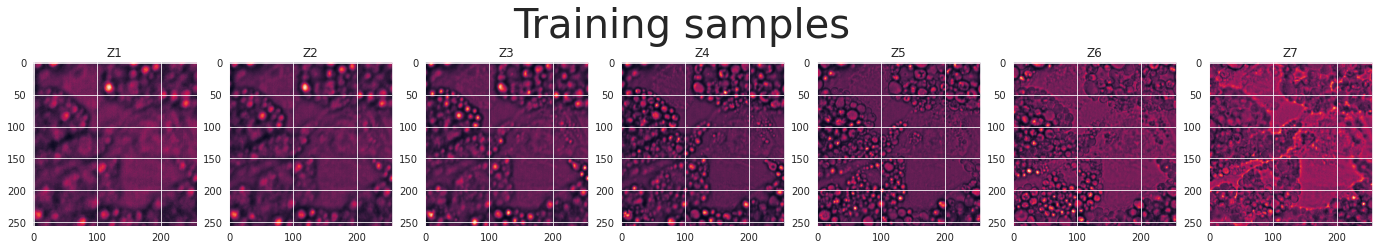

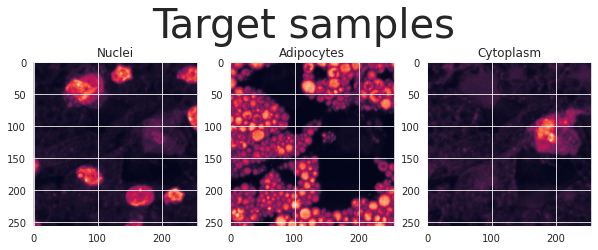

In [ ]:
# Confirm that Dataset is working
fig, ax = plt.subplots(1,7, figsize=(24,4))
fig.suptitle("Training samples", fontsize=40)
names = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7"]
for i, x_sample in enumerate(x):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample)

fig, ax = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Target samples", fontsize=40)
names = ["Nuclei", "Adipocytes", "Cytoplasm"]
for i, x_sample in enumerate(y):
    ax[i].imshow(x_sample)
    ax[i].set_title(names[i])

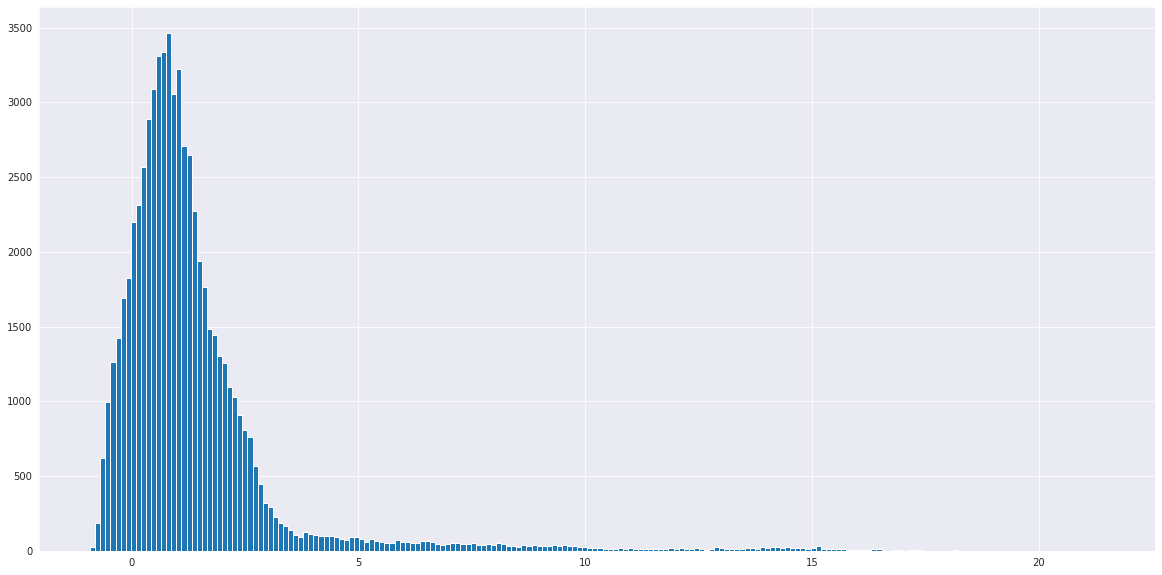

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(x_sample.numpy().ravel(), 200)
plt.show()

In [ ]:
train_dataset = ExampleDataset("/content/train/", transform=train_transforms)
valid_dataset = ExampleDataset("/content/valid/", transform=valid_transforms)

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

# Testing
x, y = next(iter(train_dataloader))
print(x.shape, y.shape)

x, y = next(iter(valid_dataloader))
print(x.shape, y.shape)

del x, y

torch.Size([2, 7, 256, 256]) torch.Size([2, 3, 256, 256])
torch.Size([2, 7, 256, 256]) torch.Size([2, 3, 256, 256])


# Training with UNet

To use UNet, we do the following
1. Obtain pretrained UNet model
2. Change input layer to fit 7 channels
3. Change output layer to output 3 channels


## Data Science Bowl 2018 1st winner:
- They suggest these following backbones for best performance: 
  - DPN-92
  - Resnet-152 (This notebook)
  - InceptionResnetV2
  - Resnet101

In [ ]:
class UNet(nn.Module):
    """Just a basic UNet model.

    https://github.com/milesial/Pytorch-UNet
    """
    def __init__(self, input_channels=7, output_channels=3):
        super(UNet, self).__init__()

        # Get model from PyTorch hub
        net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')

        # Configure input layer to take 7 channels
        net.inc.double_conv[0] = nn.Conv2d(
            input_channels, 
            net.inc.double_conv[0].out_channels, 
            kernel_size = net.inc.double_conv[0].kernel_size, 
            stride = net.inc.double_conv[0].stride, 
            padding = net.inc.double_conv[0].padding
            )

        # Configure output layer to output 3 channels
        net.outc.conv = nn.Conv2d(
            net.outc.conv.in_channels,
            output_channels,
            kernel_size = net.outc.conv.kernel_size,
            stride = net.outc.conv.stride
        )
        self.net = net
    
    def forward(self, x):
        return self.net(x)

class UNet3P(nn.Module):
    """Just a basic UNet+++ model.

    https://github.com/frgfm/Holocron
    """
    def __init__(self, input_channels=7, output_channels=3):
        super(UNet3P, self).__init__()

        # Get model from Holocron library
        net = models.unet3p(pretrained=False)

        # Configure input layer to take 7 channels
        net.encoders[0][0] = nn.Conv2d(
            input_channels, 
            net.encoders[0][0].out_channels, 
            kernel_size = net.encoders[0][0].kernel_size, 
            stride = net.encoders[0][0].stride, 
            padding = net.encoders[0][0].padding
        )

        # Configure output layer to output 3 channels
        net.classifier = nn.Conv2d(
            net.classifier.in_channels,
            output_channels,
            kernel_size = net.classifier.kernel_size,
            stride = net.classifier.stride
        )
        self.net = net
    
    def forward(self, x):
        return self.net(x)

class UNet_with_backbone(nn.Module):
    def __init__(self, input_channels=7, output_channels=3):
        super(UNet_with_backbone, self).__init__()
        backbone = torchvision.models.resnet152(pretrained=False)
        backbone.conv1 = nn.Conv2d(
            input_channels,
            out_channels = backbone.conv1.out_channels,
            kernel_size = backbone.conv1.kernel_size,
            stride  = backbone.conv1.stride,
            bias  = backbone.conv1.bias
        )
        backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Using Fastai API to construct UNet from any encoders (ResNet152 in this case)
        UNet = DynamicUnet( 
            backbone,        # Backbone
            output_channels, # Number of classes/channels
            (256,256),       # Output shape
            norm_type=None
        )
        self.UNet = UNet

    def forward(self, x):
        return self.UNet(x)

# PyTorch training loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#models.unetp()  UNet+
#models.unetpp() UNet++
#models.unet3p() UNet+++

# Test inference
model = UNet_with_backbone(input_channels=7, output_channels=3)
wandb.watch(model)

criterion = nn.L1Loss()
#kldiv = nn.KLDivLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
os.makedirs('/content/drive/My Drive/AstraZeneca/UNetResNet152', exist_ok=True)

weight_files = glob.glob('/content/drive/My Drive/AstraZeneca/UNetResNet152/model_*.pth')
if len(weight_files) != 0:
    iterations = [int(os.path.basename(weight_file).replace("model_", "").replace(".pth", "")) for weight_file in weight_files]
    idx = np.argmax(iterations)
    WEIGHT_FILE = weight_files[idx]
    print(f"Using weight file: {WEIGHT_FILE}")

try:
    print("Loading model ...")
    checkpoint = torch.load(WEIGHT_FILE, map_location=device)
    epoch = checkpoint['epoch']
    all_A1_train_losses = checkpoint['A1_train_losses'] 
    all_A2_train_losses = checkpoint['A2_train_losses']
    all_A3_train_losses = checkpoint['A3_train_losses']
    all_A1_valid_losses = checkpoint['A1_valid_losses']
    all_A2_valid_losses = checkpoint['A2_valid_losses']
    all_A3_valid_losses = checkpoint['A3_valid_losses']

    print(f"Starting from epoch {epoch}")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    print("Model state successfully loaded.")
except:
    print("Starting from the beginning...")
    epoch = 0
    model.to(device)
    all_A1_train_losses = list()
    all_A2_train_losses = list()
    all_A3_train_losses = list()
    all_A1_valid_losses = list()
    all_A2_valid_losses = list()
    all_A3_valid_losses = list()
    print(f"Starting from epoch {epoch}")
    
  

Using weight file: /content/drive/My Drive/AstraZeneca/UNetResNet152/model_99.pth
Loading model ...
Starting from epoch 100
Starting from the beginning...
Starting from epoch 0


In [ ]:
    print("Loading model ...")
    checkpoint = torch.load('/content/drive/My Drive/AstraZeneca/UNetResNet152/model_39.pth', map_location=device)
    epoch = checkpoint['epoch']
    all_A1_train_losses = checkpoint['A1_train_losses'] 
    all_A2_train_losses = checkpoint['A2_train_losses']
    all_A3_train_losses = checkpoint['A3_train_losses']
    all_A1_valid_losses = checkpoint['A1_valid_losses']
    all_A2_valid_losses = checkpoint['A2_valid_losses']
    all_A3_valid_losses = checkpoint['A3_valid_losses']

    print(f"Starting from epoch {epoch}")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    print("Model state successfully loaded.")

Loading model ...
Starting from epoch 40


NameError: ignored

In [ ]:
epochs = 200

for epoch in range(epoch, epochs):
    model.train()

    A1_train_losses = list()
    A2_train_losses = list()
    A3_train_losses = list()
    batch_train_losses = list()
    with tqdm(total=len(train_dataset), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for inputs, targets in train_dataloader:

            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            
            assert not torch.isnan(inputs).any()  # Input
            assert not torch.isnan(targets).any() # targets
            preds = model(inputs)
            assert not torch.isnan(preds).any() # preds
            loss = criterion(preds, targets) #+ (kldiv(preds, targets) + kldiv(targets, preds))/2

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()

            pred = post_process(preds.detach().cpu())
            targets = post_process(targets.cpu())

            comp_loss_A1 = criterion(pred[:,0], targets[:,0]).item()
            comp_loss_A2 = criterion(pred[:,1], targets[:,1]).item()
            comp_loss_A3 = criterion(pred[:,2], targets[:,2]).item()

            A1_train_losses.append(comp_loss_A1)
            A2_train_losses.append(comp_loss_A2)
            A3_train_losses.append(comp_loss_A3)
            batch_train_losses.append(loss.item())
            pbar.set_postfix(**{'Train loss (batch)': np.mean(batch_train_losses), "A1": np.mean(A1_train_losses), "A2": np.mean(A2_train_losses), "A3": np.mean(A3_train_losses)})
            pbar.update(inputs.shape[0])

            del comp_loss_A1, comp_loss_A2, comp_loss_A3
            del inputs, pred, targets, loss
            #torch.cuda.empty_cache()

    all_A1_train_losses.append(np.mean(A1_train_losses))
    all_A2_train_losses.append(np.mean(A2_train_losses))
    all_A3_train_losses.append(np.mean(A3_train_losses))


    A1_valid_losses = list()
    A2_valid_losses = list()
    A3_valid_losses = list()
    batch_valid_losses = list()

    # Set dropout and batchnorm to inference mode
    model.eval()
    # Turn off history tracking (No gradient can be calculated)
    with torch.no_grad():
        with tqdm(total=len(valid_dataset), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for inputs, targets in valid_dataloader:

                inputs = inputs.to(device=device, dtype=torch.float32)
                targets = targets.to(device, dtype=torch.float32)
                
                assert not torch.isnan(inputs).any()  # Input
                assert not torch.isnan(targets).any() # targets
                preds = model(inputs)
                assert not torch.isnan(preds).any() # preds
                loss = criterion(preds, targets)

                pred = post_process(preds.detach().cpu())
                targets = post_process(targets.cpu())
                comp_loss_A1 = criterion(pred[:,0], targets[:,0]).item()
                comp_loss_A2 = criterion(pred[:,1], targets[:,1]).item()
                comp_loss_A3 = criterion(pred[:,2], targets[:,2]).item()

                A1_valid_losses.append(comp_loss_A1)
                A2_valid_losses.append(comp_loss_A2)
                A3_valid_losses.append(comp_loss_A3)
                batch_valid_losses.append(loss.item())
                pbar.set_postfix(**{'Valid loss (batch)': np.mean(batch_valid_losses), "A1": np.mean(A1_valid_losses), "A2": np.mean(A2_valid_losses), "A3": np.mean(A3_valid_losses)})
                pbar.update(inputs.shape[0])

    all_A1_valid_losses.append(np.mean(A1_valid_losses))
    all_A2_valid_losses.append(np.mean(A2_valid_losses))
    all_A3_valid_losses.append(np.mean(A3_valid_losses))

    # Logging using Weight and Biases once every epoch
    wandb.log({
        "Epochs": epoch,
        "A1 Train loss:": all_A1_train_losses[-1], 
        "A2 Train loss:": all_A2_train_losses[-1],
        "A3 Train loss:": all_A3_train_losses[-1],
        "A1 Valid loss:": all_A1_valid_losses[-1], 
        "A2 Valid loss:": all_A2_valid_losses[-1],
        "A3 Valid loss:": all_A3_valid_losses[-1]
    })

    # Checkpoint every 5 epochs
    if (epoch+1) % 10 == 0:

        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'A1_train_losses': all_A1_train_losses,
                    'A2_train_losses': all_A2_train_losses,
                    'A3_train_losses': all_A3_train_losses,
                    'A1_valid_losses': all_A1_valid_losses,
                    'A2_valid_losses': all_A2_valid_losses,
                    'A3_valid_losses': all_A3_valid_losses,
                    'optimizer_state_dict': optimizer.state_dict()},
                  f'/content/drive/My Drive/AstraZeneca/UNetResNet152/model_{epoch}.pth')       
    
# Checkpoint final epoch
torch.save({'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'A1_train_losses': all_A1_train_losses,
            'A2_train_losses': all_A2_train_losses,
            'A3_train_losses': all_A3_train_losses,
            'A1_valid_losses': all_A1_valid_losses,
            'A2_valid_losses': all_A2_valid_losses,
            'A3_valid_losses': all_A3_valid_losses,
            'optimizer_state_dict': optimizer.state_dict()},
          f'/content/drive/My Drive/AstraZeneca/UNetResNet152/model_{epoch}.pth') 

KeyboardInterrupt: ignored

In [ ]:
# Save model to wandb
torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

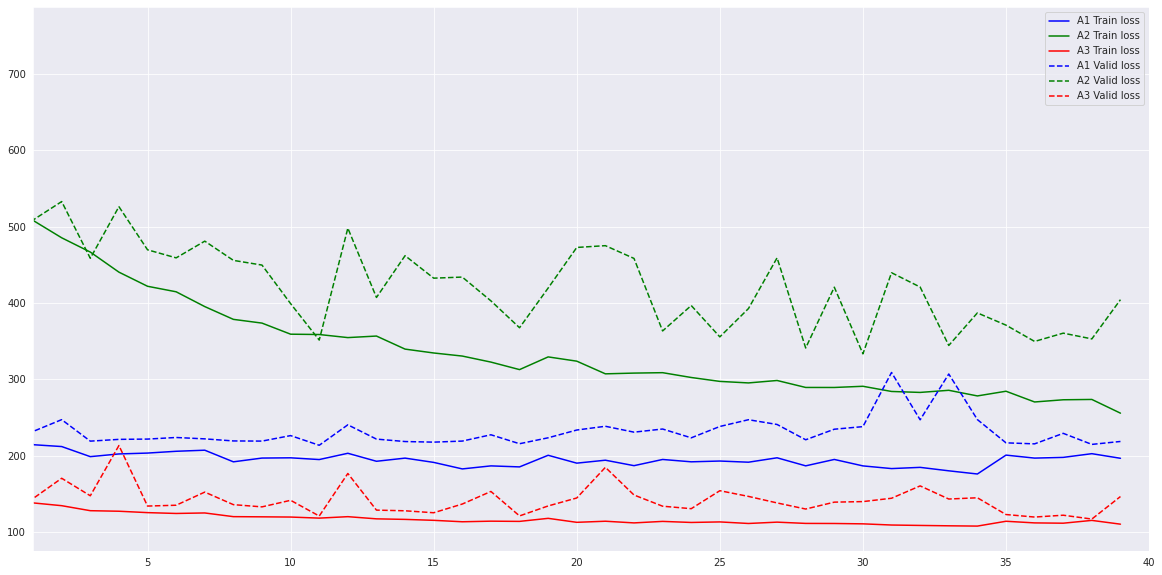

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(all_A1_train_losses, color="b")
plt.plot(all_A2_train_losses, color="g")
plt.plot(all_A3_train_losses, color="r")

plt.plot(all_A1_valid_losses, "--", color="b")
plt.plot(all_A2_valid_losses, "--", color="g")
plt.plot(all_A3_valid_losses, "--", color="r")
plt.legend(["A1 Train loss", "A2 Train loss", "A3 Train loss", 
            "A1 Valid loss", "A2 Valid loss", "A3 Valid loss"])

#plt.xscale("log")
#plt.ylim([0, 600])
plt.xlim([1, len(all_A2_valid_losses)])
plt.show()

# ResNet152 Pretrained     - Epoch 40/40: 100% 200/200 [02:27<00:00, 1.36img/s, A1=1.79e+5, A2=1.56e+5, A3=2.70e+4, loss (batch)=0.456]
# ResNet152 Not Pretrained - Epoch 40/40: 100% 200/200 [02:24<00:00, 1.39img/s, A1=1.89e+5, A2=2.17e+5, A3=2.85e+4, loss (batch)=0.502]

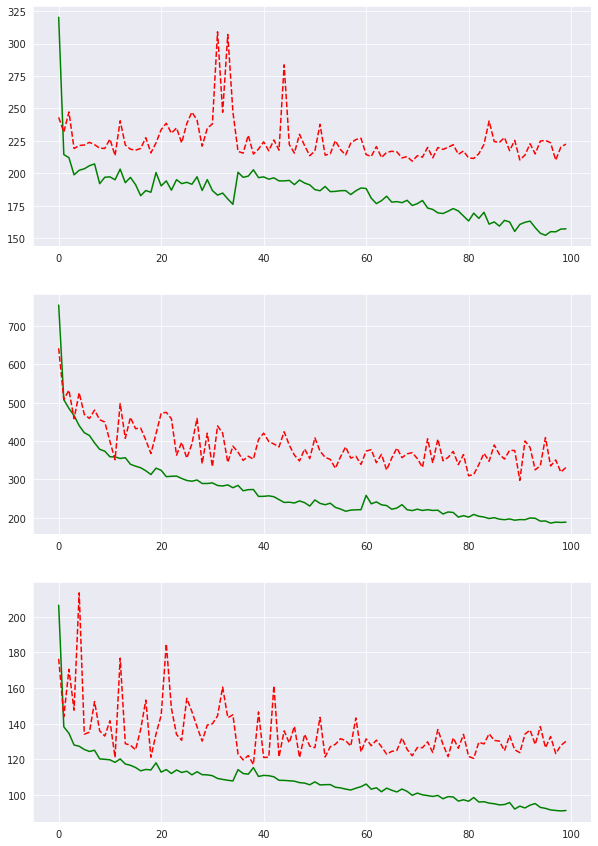

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,15))
data = [
    (all_A1_train_losses, all_A1_valid_losses), 
    (all_A2_train_losses, all_A2_valid_losses), 
    (all_A3_train_losses, all_A3_valid_losses)
    
]
for ax, (train_results, valid_results) in zip(axs, data):

    ax.plot(train_results, color="g")
    ax.plot(valid_results, "--", color="r")
    #ax.legend(["A2 Train loss", 
    #            "A2 Valid loss"])
    #plt.xscale("log")
    #plt.ylim([0, 850000])
    #ax.xlim([1, len(all_A2_valid_losses)])
fig.show()

# ResNet152 Pretrained     - Epoch 40/40: 100% 200/200 [02:27<00:00, 1.36img/s, A1=1.79e+5, A2=1.56e+5, A3=2.70e+4, loss (batch)=0.456]
# ResNet152 Not Pretrained - Epoch 40/40: 100% 200/200 [02:24<00:00, 1.39img/s, A1=1.89e+5, A2=2.17e+5, A3=2.85e+4, loss (batch)=0.502]

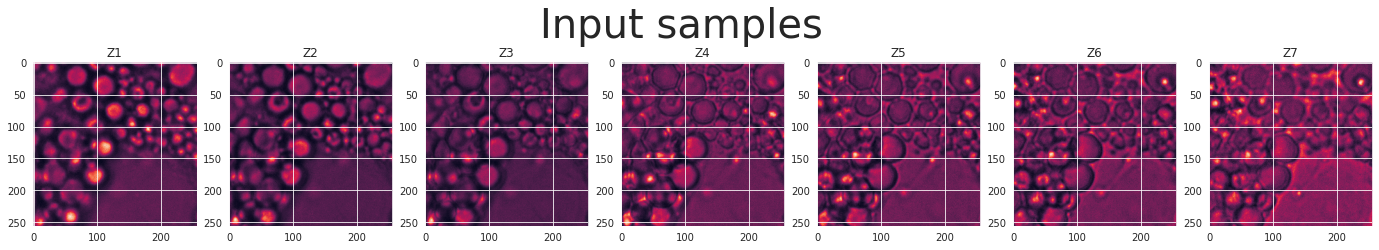

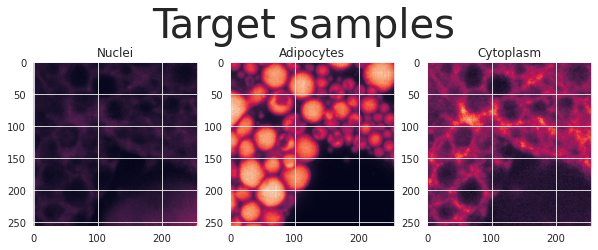

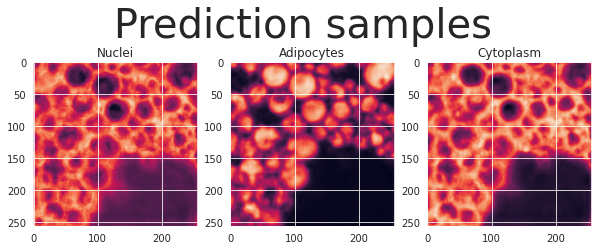

In [ ]:
# Sample inference and visualization
x, y = valid_dataset[1]
fig, ax = plt.subplots(1,7, figsize=(24,4))
fig.suptitle("Input samples", fontsize=40)
names = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7"]
for i, x_sample in enumerate(x):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample)

fig, ax = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Target samples", fontsize=40)
names = ["Nuclei", "Adipocytes", "Cytoplasm"]
for i, x_sample in enumerate(y):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample)

model.eval().to(device)
preds = model(x.unsqueeze(0).to(device)).cpu()
fig, ax = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Prediction samples", fontsize=40)
names = ["Nuclei", "Adipocytes", "Cytoplasm"]
for i, x_sample in enumerate(preds[0]):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample.detach().numpy())
    

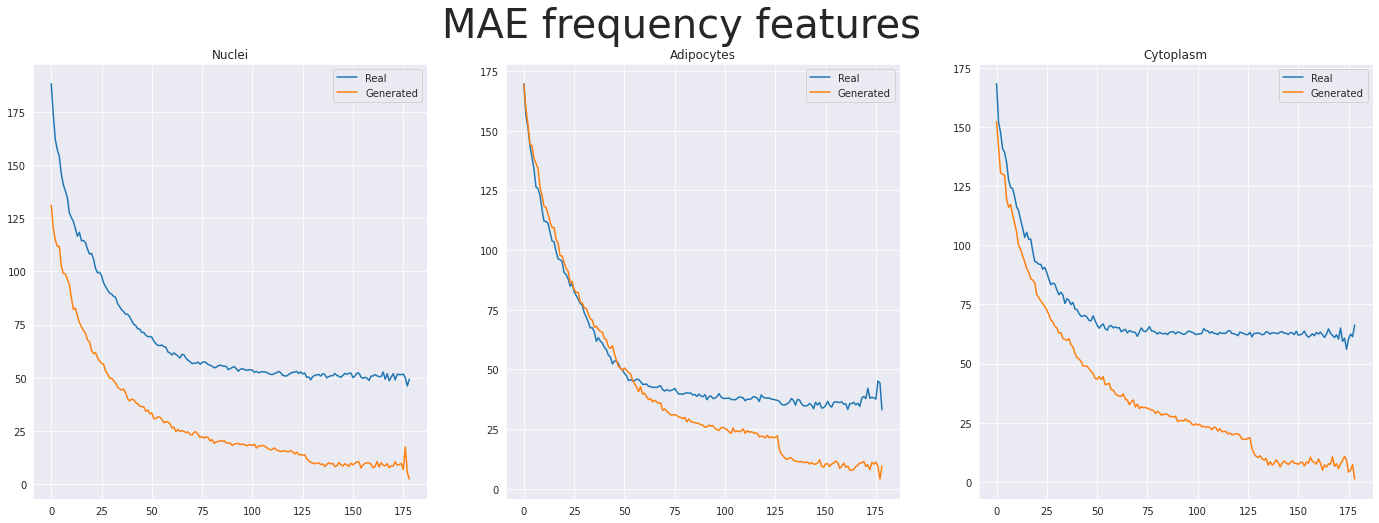

In [ ]:
# from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def plot_power_curve(img, epsilon=1e-10):
    img = np.array(img)
    # Calculate FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)
    return psd1D


with torch.no_grad():

    x, y = valid_dataset[200]
    model.eval().to(device)
    preds = model(x.unsqueeze(0).to(device)).cpu()
    fig, ax = plt.subplots(1,3, figsize=(24,8))
    fig.suptitle("MAE frequency features", fontsize=40)
    names = ["Nuclei", "Adipocytes", "Cytoplasm"]
    for i, x_sample in enumerate(preds[0]):
        ax[i].set_title(names[i])
        ax[i].plot(plot_power_curve(y[i]))
        ax[i].plot(plot_power_curve(x_sample.detach().numpy()))
        ax[i].legend(["Real", "Generated"])
        

In [ ]:
def visualize_sample(model, x,y):
    model.eval()
    fig, ax = plt.subplots(1,7, figsize=(24,15))
    names = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7"]
    for i, x_sample in enumerate(x):
        ax[i].set_title(names[i])
        ax[i].imshow(x_sample)

    fig, ax = plt.subplots(1,3, figsize=(10,6))
    fig.suptitle("Target samples", fontsize=40)
    names = ["Nuclei", "Adipocytes", "Cytoplasm"]
    for i, x_sample in enumerate(y):
        ax[i].set_title(names[i])
        ax[i].imshow(x_sample)

    model.eval().to(device)
    preds = model(x.unsqueeze(0).to(device)).cpu()
    fig, ax = plt.subplots(1,3, figsize=(10,6))
    fig.suptitle("Prediction samples", fontsize=40)
    names = ["Nuclei", "Adipocytes", "Cytoplasm"]
    for i, x_sample in enumerate(preds[0]):
        ax[i].set_title(names[i])
        ax[i].imshow(x_sample.detach().numpy())
        

In [ ]:
torch.save(model.state_dict(),
           f'UNet_ResNet152_epoch{40}.pth')

In [ ]:
40